# Practical session n°3

Notions:
- Training from scratch
- Validation step
- Learning curves
- Transfer learning
- Fine tuning
- Freezing

Duration: 2 h

Now that we have covered the basic building blocks, we will train a Convolutional Neural Network (CNN) on slightly more challenging problems than separation of points in a 2D space:
- handwritten digit recognition (part **I.**)
- binary classification of photos (part **II.**)

The first machine learning problem will give us the opportunity to train a tiny CNN from scratch through a complete training loop (including training and validation steps).
An efficient training from scratch on the second problem would need much more images than the few available photos (200). We hence use one of the most interesting features of the neural networks: once trained on a very big dataset on a very general task, they could be "retrained" (one says fine tuned) on a very specific task that share the same inputs. As such pretrained neural network are much bigger than our first tiny CNN, a graphics card will be used to significantly speed up the process.

### **I.A.** The MNIST Database of Handwritten Digit

The Database of Handwritten Digit of the NIST (National Institute of Standards and Technologogies) comprises 70,000 black and white  images of handwritten digits of 28x28 pixels. A specific dataset object is allocated to it in the torchvision.datasets module. \\
The subsequent cells are designed to import packages, download the MNIST database, define dataLoaders and showcase some images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import time

In [2]:
# transforms (format/normalization)
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])

# Definition of training sets:
trainval_dataset = datasets.MNIST(root='./data',
                                  train=True,
                                  download=True,
                                  transform=tr)

# Split indices for training and validation
num_images = len(trainval_dataset)
indices = list(range(num_images))
split = int(np.floor(0.2 * num_images))  # 20% validation

# Shuffle indices
np.random.seed(42)  # Seed for reproducibility
np.random.shuffle(indices)

# Create train and validation samplers
train_indices, val_indices = indices[split:], indices[:split]

from torch.utils.data import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_size = len(train_sampler)
val_size = len(val_sampler)

# Definition of the train/val loaders
bs = 8
num_workers = 2 # try : print(os.cpu_count())

train_loader = DataLoader(trainval_dataset, batch_size=bs,
                          sampler=train_sampler, num_workers=num_workers)
val_loader = DataLoader(trainval_dataset, batch_size=bs,
                        sampler=val_sampler, num_workers=num_workers)

torch.Size([8, 1, 28, 28])


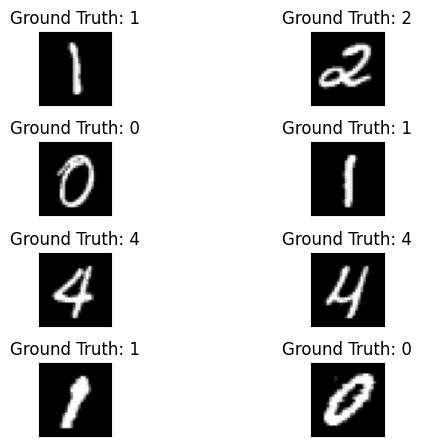

In [3]:
x, t = next(iter(train_loader))

print(x.shape)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(x[i,0,:,:], cmap='gray') #, interpolation='none')
  plt.title("Ground Truth: {}".format(t[i]))
  plt.xticks([])
  plt.yticks([])

**Exercise 1**:
- Are images sampled by train_loader and val_loader normalized?
- How much images are in *train_loader* and *val_loader*?
- What will be the role of the validation loader?

In [4]:
# Yes: torchvision.transforms.Normalize((0.1307,), (0.3081,))

print("nb images train set : ",len(train_indices))
print("nb images val set : ",len(val_indices))

# Roles:
# - surveiller les perf en generalistion


nb images train set :  48000
nb images val set :  12000


### **I.B.** A vanilla CNN

Now, we will define a vanilla CNN with two convolution layers.

**Exercise 2:**  Determine *N* in such a way that the network can accept MNIST images as input.
How outputs will be interpreted after the training ?

In [5]:
N = 490 # 7*7*10

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # convert an image to a 1D torch.tensor:
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### **I.C.** Training of the CNN

To train a CNN, let's define a loss function. Since the log of output probabilities has been computed with *F.log_softmax*, we only need to gather the logits associated with the target classes. This can be done with the torch.gather function (see **P1**), but the standard way in PyTorch is to use *torch.nn.NLLLoss()*.

In [10]:
model = CNN()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# NLLLoss() will have the same effect as torch.gather (see TP1)
loss_fn =  torch.nn.NLLLoss()

A complete training loop has (at least) two phases: weights are updated only in the first phase dedicated to training. During the validation phase, **generalization performance** on independent images is monitored.

**Exercise 3**:
Complete the following code to print the mean loss and the accuracy on the train and validation sets.


In [7]:
import time

num_epochs = 2

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    running_loss_train = 0.0
    running_corrects_train = 0
    running_loss_val = 0.0
    running_corrects_val = 0

    # Phase 1: Training
    model.train()  # Set the model to training mode
    for x, label in train_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Update counters:
        running_loss_train += loss.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores (todo):
    epoch_loss_train = running_loss_train/train_size
    epoch_acc_train = running_corrects_train/train_size

    print(f'Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}')

    # Phase 2: Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x, label in val_loader:
            output = model(x)
            loss = loss_fn(output, label)

            # Get predicted classes:
            _, preds = torch.max(output, 1)

            # Update counters:
            running_loss_val += loss.item() * x.shape[0]
            running_corrects_val += torch.sum(preds == label.data)

    # Calculate validation scores (todo):
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val / val_size

    print(f'Validation Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}')

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

    # Update start time for the next epoch
    start_time = time.time()

Epoch: 0
Train Loss: 0.2937 Acc: 0.9073
Validation Loss: 0.0759 Acc: 0.9767
Time: 57 seconds
Epoch: 1
Train Loss: 0.1381 Acc: 0.9584


KeyboardInterrupt: 

In [ ]:
train_losses = []
val_losses = []

train_accs = []
val_accs = []

### BEGIN SOLUTION

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = model(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')


### END SOLUTION

**Exercise 4**:
At each epoch, store the accuracy and the cost function value in the lists *train_losses*, *val_losses*, *train_accs*, and *val_accs*.
Plot the **learning curves** over six epochs. \\

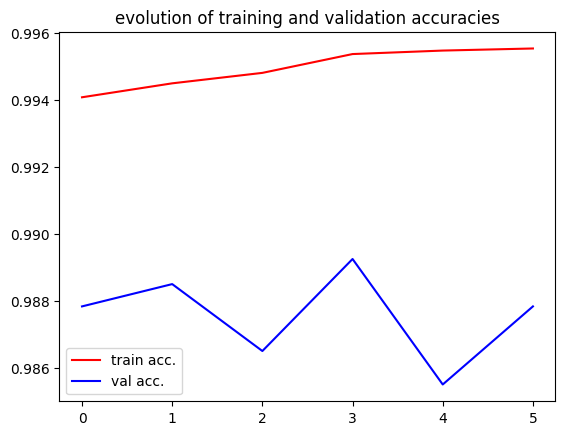

In [ ]:
fig, ax = plt.subplots()
plt.title('evolution of training and validation accuracies')

ax.plot( train_accs , color = 'r')
ax.plot( val_accs , color = 'b')
ax.legend(['train acc.', 'val acc.'])


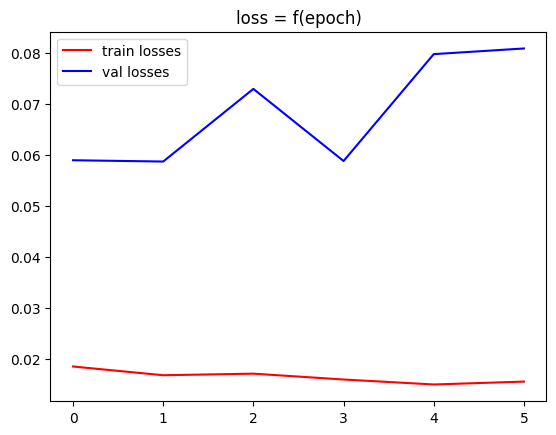

In [ ]:
fig2, ax2 = plt.subplots()
plt.title('loss = f(epoch)')
ax2.plot( train_losses,  color = 'r')
ax2.plot( val_losses, color = 'b')
ax2.legend(['train losses', 'val losses'])

**Exercise 5:** Complete the following perceptron (P60) to directly take MNIST images as input.
Compare the standalone perceptron to the CNN in terms of size (number of weights) and performance on a test set.

In [ ]:
class P60(nn.Module):

    def __init__(self):
        super(P60, self).__init__()
        self.fc1 = nn.Linear(... , 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # flattening x
        x = x.view(-1, ...)

        # apply first layer
        x = F.relu(self.fc1(x))

        # apply second layer
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

perceptron = P60()
optimizer = torch.optim.Adam(perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

In [ ]:
# Size comparison:

...

In [ ]:
# Performance comparison (on the validation set):

...

### **II.A.** Load and viz the Hymenoptera dataset:

Through a second image classification problem, we focus on two other important aspects of deep learning: speeding up the learning with GPU cards and the ability to use pretrained networks.

To illustrate the first aspect, we will use the GPUs available under Google Colab. To do this, before starting this part, go to **Modifier**/**Modifier les param du notebook** and select a GPU.

In [10]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda:0") # 0 is the index of the GPU
  print(torch.cuda.get_device_name(device))
else:
  print('Change the runtime type to GPU')

Tesla T4


Now let's download inputs (RGB images of bees or ants) and targets ("bee" or "ant").

In [11]:
# download the dataset
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip -qq hymenoptera_data.zip

--2024-11-08 13:40:18--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.165.116.45, 18.165.116.18, 18.165.116.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.165.116.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   226MB/s    in 0.2s    

2024-11-08 13:40:18 (226 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [12]:
dir_data = 'hymenoptera_data'
print(os.listdir(dir_data))

['val', 'train']


The dataset is in a standard format, and we can manipulate it with a ready-to-use dataset object of the datasets.ImageFolder class:

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print('Dataset sizs:' )
print(dataset_sizes)

Dataset sizs:
{'train': 244, 'val': 153}


Since the provided dataset is very small, we need to maximize its utility. We will produce new images through additional transformations that preserve the nature of the object (data augmentation). \\
In the code, transforms.*RandomResizedCrop()*, *transforms.RandomHorizontalFlip()* and *transforms.RandomVerticalFlip()* apply horizontal or vertical axis symmetry with a probability of 1/2. Note that these transformations might not be suitable for other datasets like MNIST since the mirror image of a digit is generally not another digit. \\
Some images are presented below.

In [14]:
def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
      plt.imshow(inp)
      plt.title(title)
    else:
      ax.imshow(inp)
      ax.set_title(title)

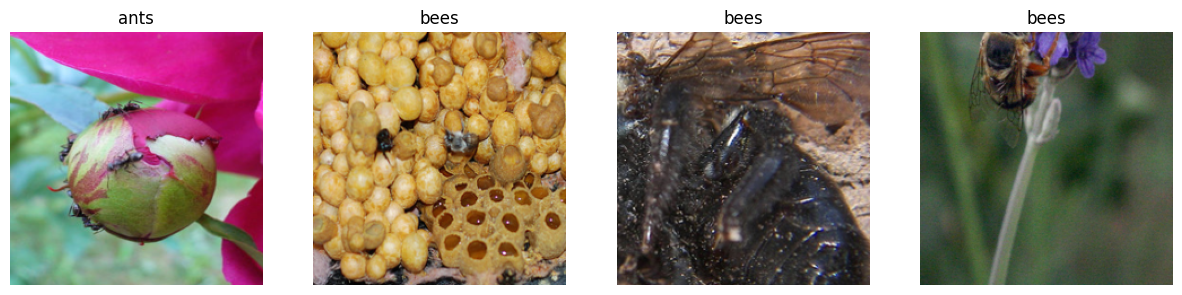

In [15]:
def plot_batch(images, labels, class_names):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axs[i].axis('off')
        imshow(images[i],axs[i],class_names[labels[i]])
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
class_names = image_datasets['train'].classes
# Assuming `inputs` is a batch of images and `classes` are the corresponding class labels
plot_batch(inputs, classes, class_names)

### **II.B.** Using a Graphics Card:

In this part, the lightest of the ResNet architectures is adapted to our binary classification problem and trained over one epoch.

**Exercise 6:**

- Load an untrained ResNet18. How many total weights does it contain? Check [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

- How many neurons does the last layer of the network have?

- Is there a softmax operation at the end of *ResNet.forward()*?

- Modify the last layer of the classifier so that it has as many neurons as there are classes in hymenoptera_data.

In [16]:
model = models.resnet18(pretrained=False)

# num of weights
num_weights =0

for module in model.modules():
  if isinstance(module,nn.Conv2d) or isinstance(module,nn.Linear) or isinstance(module,nn.BatchNorm2d):
    for param in module.parameters():
      num_weights += param.numel()

print(num_weights)

11689512


In [17]:
print(model.fc)
print(model.fc.out_features,'neurons')

Linear(in_features=512, out_features=1000, bias=True)
1000 neurons


In [18]:
# Modification of the last layer of the classifier
def get_model(pretrained):
  model = models.resnet18(pretrained=pretrained)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)

  return model

model = get_model(False)

Now, let's define the negative log-likelihood as the cost function. To compute the log-likelihood, we could add a LogSoftmax layer to the ResNet. Another common way to do that is to use a loss function that includes *LogSoftmax*. In this regard, in PyTorch,  *nn.CrossEntropyLoss* combines both *LogSoftmax* and *NLLLoss*.

In [19]:
loss_fn = nn.CrossEntropyLoss()

Finally, let's define a function that incorporates the training loop:

In [7]:
def train_model(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                # Weights are not updated during the validation phase

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

**Exercise 7:** With the *train_model* function, train the ResNet over one epoch with mini-batches of 64 images.

In [20]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
              for x in ['train', 'val']}

In [27]:
%%timeit -n 1 -r 2
model = get_model(pretrained=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training over 1 epoch:
model_trained = train_model(dataloaders, model, loss_fn, optimizer, num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.6957 Acc: 52.05%
val Loss: 0.6906 Acc: 52.94%
Training complete in 1m 15s
Epoch 0/0
----------
train Loss: 0.6850 Acc: 53.69%
val Loss: 0.6897 Acc: 51.63%
Training complete in 1m 13s
1min 14s ± 600 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


### **II.C.** Using a Graphics Card:

With more than 10 million parameters, training a ResNet18 on a CPU is much slower than the networks in Part I. \\
Let's repeat the same training using the GPU.

In [28]:
print(f'Runtime device :{device}')

# Load the model to the GPU:
model = model.to(device)

Runtime device :cuda:0


To load a torch.tensor on GPU, the syntax is the same:

In [29]:
x = torch.rand(2,1,4,4)
print("On CPU :\n",x)
x = x.to(device)
# Note: You can also use .cuda() without specifying the device name
# but this method is not recommended especially in a multi-gpu environment
print("On GPU :\n",x)

# bring back the x tensor to the CPU RAM:
x = x.to('cpu') # or x.cpu()
print('Back to CPU:\n',x)

On CPU :
 tensor([[[[0.0255, 0.2028, 0.0780, 0.8082],
          [0.4332, 0.8924, 0.3887, 0.8678],
          [0.5465, 0.5209, 0.3446, 0.1499],
          [0.0507, 0.1186, 0.7426, 0.4612]]],


        [[[0.3147, 0.7611, 0.8786, 0.4572],
          [0.8239, 0.9939, 0.2256, 0.9264],
          [0.4318, 0.0111, 0.8237, 0.3222],
          [0.2082, 0.3795, 0.3583, 0.5508]]]])
On GPU :
 tensor([[[[0.0255, 0.2028, 0.0780, 0.8082],
          [0.4332, 0.8924, 0.3887, 0.8678],
          [0.5465, 0.5209, 0.3446, 0.1499],
          [0.0507, 0.1186, 0.7426, 0.4612]]],


        [[[0.3147, 0.7611, 0.8786, 0.4572],
          [0.8239, 0.9939, 0.2256, 0.9264],
          [0.4318, 0.0111, 0.8237, 0.3222],
          [0.2082, 0.3795, 0.3583, 0.5508]]]], device='cuda:0')
Back to CPU:
 tensor([[[[0.0255, 0.2028, 0.0780, 0.8082],
          [0.4332, 0.8924, 0.3887, 0.8678],
          [0.5465, 0.5209, 0.3446, 0.1499],
          [0.0507, 0.1186, 0.7426, 0.4612]]],


        [[[0.3147, 0.7611, 0.8786, 0.4572],
       

**Exercise 8:**
- Complete the fonction *train_model_gpu* to train the model on GPU.
- Compare the CPU and GPU training times.
- What are the validation scores after 20 epochs on GPUs ?

In [32]:
def train_model_gpu(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Move inputs to GPU
                labels = labels.to(device) # Move labels to GPU

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model


### **II.D.** Impact of pretraining on performance:

Training is faster on a GPU, but it only leads to a very poor score, barely better than random chance. To improve performance, a simple idea is to use a network trained on a similar (or more general) task as a starting point for learning. Here, it works particularly well with networks trained on ImageNet, whose convolutional filters are already very rich.

**Note:**
This method is refered to as **fine-tuning** a **pretrained model**.

**Exercise 9:** Compare two ResNet18 trainings, one randomly initialized and the other pre-trained, using learning curves, over 25 epochs.

In [35]:
max_epochs = 25

# Learning "from scratch" (random weights):
model_scratch = get_model(pretrained=False)  # Get the model with random weights
model_scratch = model_scratch.to(device)   # Put the model on GPU

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_scratch.parameters(), lr=0.001)

# Start the training using train_model_gpu
model_scratch = train_model_gpu(dataloaders, model_scratch, loss_fn, optimizer, num_epochs=max_epochs)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.7549 Acc: 0.4959
val Loss: 0.6788 Acc: 0.5425
Epoch 1/24
----------
train Loss: 0.7003 Acc: 0.5000
val Loss: 0.6897 Acc: 0.5621
Epoch 2/24
----------
train Loss: 0.6920 Acc: 0.5041
val Loss: 0.6926 Acc: 0.5359
Epoch 3/24
----------
train Loss: 0.6766 Acc: 0.5287
val Loss: 0.6919 Acc: 0.5359
Epoch 4/24
----------
train Loss: 0.6863 Acc: 0.5287
val Loss: 0.6910 Acc: 0.5621
Epoch 5/24
----------
train Loss: 0.6737 Acc: 0.5615
val Loss: 0.6841 Acc: 0.5752
Epoch 6/24
----------
train Loss: 0.6715 Acc: 0.5615
val Loss: 0.6784 Acc: 0.6209
Epoch 7/24
----------
train Loss: 0.6596 Acc: 0.6393
val Loss: 0.6711 Acc: 0.6405
Epoch 8/24
----------
train Loss: 0.6617 Acc: 0.6189
val Loss: 0.6658 Acc: 0.5948
Epoch 9/24
----------
train Loss: 0.6639 Acc: 0.5861
val Loss: 0.6577 Acc: 0.6078
Epoch 10/24
----------
train Loss: 0.6682 Acc: 0.5861
val Loss: 0.6500 Acc: 0.6405
Epoch 11/24
----------
train Loss: 0.6607 Acc: 0.6107
val Loss: 0.6466 Acc: 0.6340
Epoch 12/24
--

In [36]:
# Fine-tuning a pretrained model:
model_ft = get_model(pretrained=True)  # Get the pretrained model
model_ft = model_ft.to(device)    # Put the model on GPU

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001)

# Start the training using train_model_gpu
model_ft = train_model_gpu(dataloaders, model_ft, loss_fn, optimizer_ft, num_epochs=max_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.7184 Acc: 0.5287
val Loss: 0.6137 Acc: 0.6863
Epoch 1/24
----------
train Loss: 0.6866 Acc: 0.5943
val Loss: 0.5879 Acc: 0.7059
Epoch 2/24
----------
train Loss: 0.6368 Acc: 0.6516
val Loss: 0.5624 Acc: 0.7255
Epoch 3/24
----------
train Loss: 0.6122 Acc: 0.6967
val Loss: 0.5406 Acc: 0.7712
Epoch 4/24
----------
train Loss: 0.5900 Acc: 0.7008
val Loss: 0.5207 Acc: 0.8105
Epoch 5/24
----------
train Loss: 0.5705 Acc: 0.7254
val Loss: 0.5014 Acc: 0.8170
Epoch 6/24
----------
train Loss: 0.5382 Acc: 0.7828
val Loss: 0.4833 Acc: 0.8366
Epoch 7/24
----------
train Loss: 0.5420 Acc: 0.7500
val Loss: 0.4664 Acc: 0.8562
Epoch 8/24
----------
train Loss: 0.5000 Acc: 0.8238
val Loss: 0.4494 Acc: 0.8627
Epoch 9/24
----------
train Loss: 0.5080 Acc: 0.7828
val Loss: 0.4347 Acc: 0.8889
Epoch 10/24
----------
train Loss: 0.4681 Acc: 0.8279
val Loss: 0.4193 Acc: 0.8954
Epoch 11/24
----------
train Loss: 0.4528 Acc: 0.8566
val Loss: 0.4069 Acc: 0.9085
Epoch 12/24
--

The fine-tuning approach has many variations that fit into the broader framework of **transfer learning**. Partial fine-tuning, as illustrated in the following exercise, is one of these variations.

**Exercise 10:** Instead of retraining all the weights, you can simply use the weights of the classifier. This is referred to as *freezing* the other weights during retraining. \\
Implement this approach and compare it with the previous ones.

In [37]:
model_frozen = get_model(pretrained=True)
model_frozen = model_frozen.to(device)

# freeze all the layers except the classifier (the last dense layers at end)
# using this snippet :
for name, module in model_frozen.named_children():
    if name not in ['fc']:
        for param in module.parameters():
            param.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer_frozen = torch.optim.SGD(filter(lambda p: p.requires_grad, model_frozen.parameters()), lr=0.001)

# Train the model (only the classifier will be updated)
model_frozen = train_model_gpu(dataloaders, model_frozen, loss_fn, optimizer_frozen, num_epochs=max_epochs)

Epoch 0/24
----------
train Loss: 0.7004 Acc: 0.5574
val Loss: 0.6238 Acc: 0.6536
Epoch 1/24
----------
train Loss: 0.6392 Acc: 0.6516
val Loss: 0.5931 Acc: 0.7124
Epoch 2/24
----------
train Loss: 0.6365 Acc: 0.6516
val Loss: 0.5771 Acc: 0.7320
Epoch 3/24
----------
train Loss: 0.6086 Acc: 0.6680
val Loss: 0.5643 Acc: 0.7582
Epoch 4/24
----------
train Loss: 0.5915 Acc: 0.7254
val Loss: 0.5504 Acc: 0.7712
Epoch 5/24
----------
train Loss: 0.5949 Acc: 0.7090
val Loss: 0.5368 Acc: 0.7843
Epoch 6/24
----------
train Loss: 0.5833 Acc: 0.7336
val Loss: 0.5267 Acc: 0.7908
Epoch 7/24
----------
train Loss: 0.5700 Acc: 0.7295
val Loss: 0.5155 Acc: 0.7974
Epoch 8/24
----------
train Loss: 0.5531 Acc: 0.7746
val Loss: 0.5035 Acc: 0.8235
Epoch 9/24
----------
train Loss: 0.5197 Acc: 0.7828
val Loss: 0.4940 Acc: 0.8366
Epoch 10/24
----------
train Loss: 0.5301 Acc: 0.7705
val Loss: 0.4821 Acc: 0.8562
Epoch 11/24
----------
train Loss: 0.5298 Acc: 0.7992
val Loss: 0.4717 Acc: 0.8758
Epoch 12/24
--

In the end, for this small dataset, retraining the last layer performs just as well as global training. To conclude, let's make some predictions with the model on the validation dataset:

In [38]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25,num_images//5*5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//5, 5, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j],ax,'Predicted: {}'.format(class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

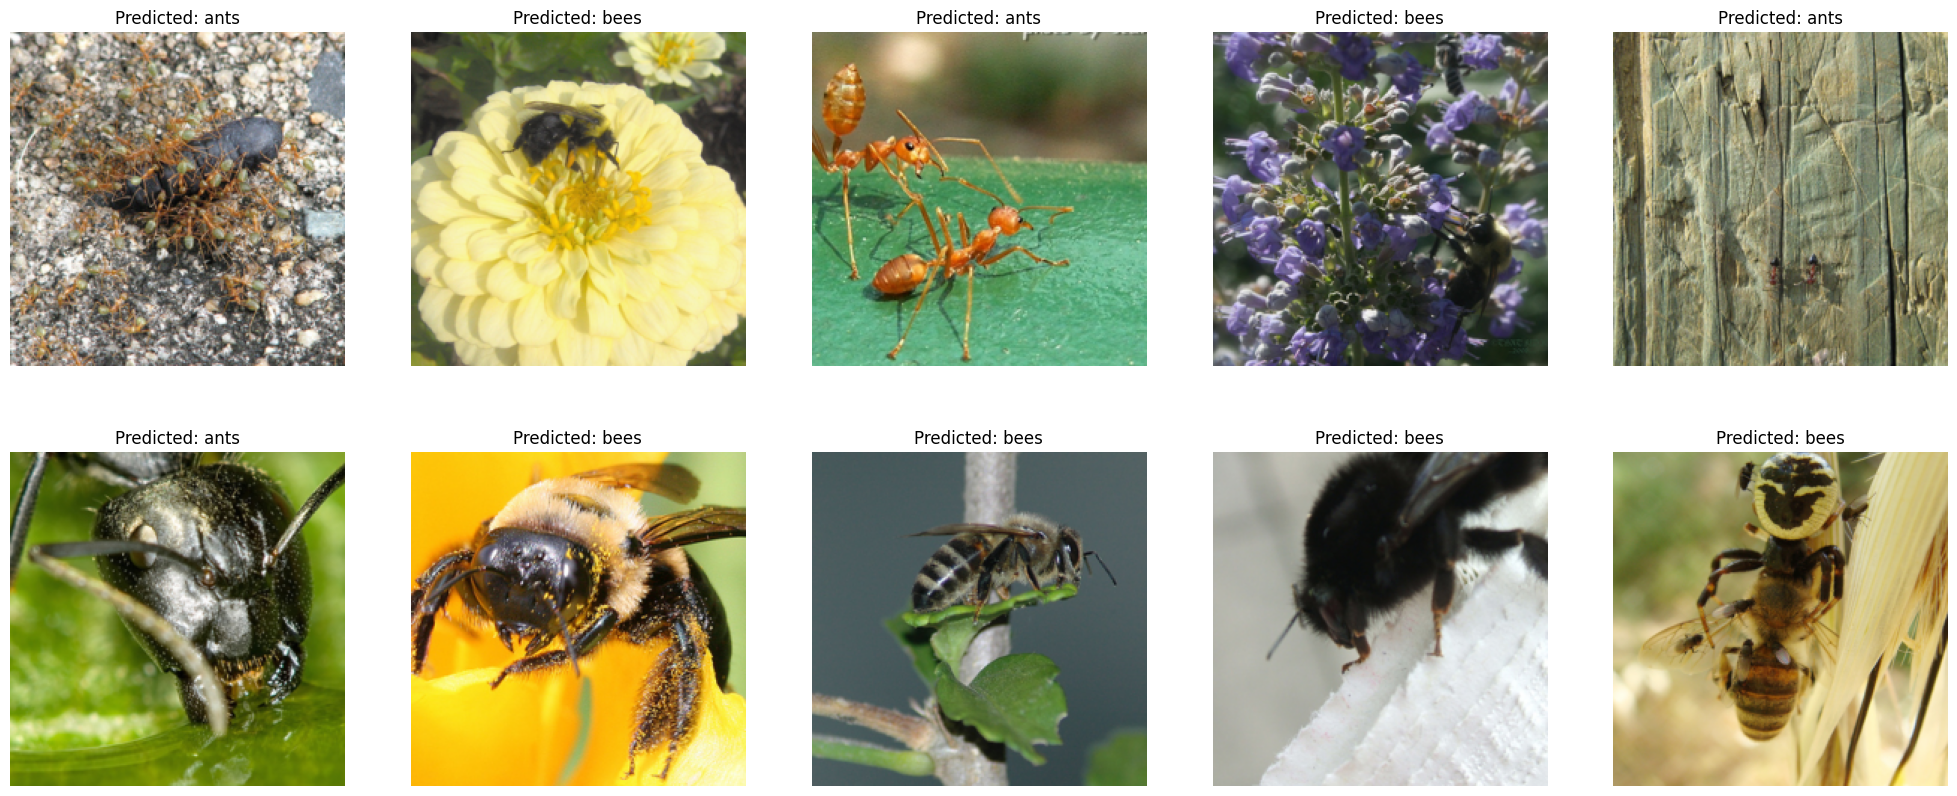

In [42]:
visualize_model(model_frozen)